In [59]:
import sys
sys.path.append("..") # this adds to path parent directory in order to import utils file
sys.path.append("../gmm/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import umap
import random
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.backends.backend_pdf


import utils


In [2]:
%load_ext autoreload
import importlib
importlib.reload(utils)

elbowAnalysis
silhouetteAnalyis


<module 'utils' from '../utils.py'>

In [3]:
# dataset = 'brainCIDR'
# df, truth = gmm_utils.loadData(dataset)

In [32]:
def getStatisticsForDataset(df, name, truth = None):
    def addStatistics(s, statistics, name = '#_cells_per_gene', reference = None):
        statistics[f'Average {name}'] = s.mean()
        if reference is not None:
            statistics[f'Percentual average {name}'] = 100 * s.mean()/reference
        statistics[f'Std {name}'] = s.std()
        statistics[f'Kurtosis {name}'] = s.kurtosis()
        statistics[f'Skew {name}'] = s.skew()
        statistics[f'Median {name}'] = s.median()
        return statistics
    
    ## Calculate statistics
    statistics = {}
    statistics['name'] = name
    statistics['Total number of cells'] = df.shape[0]
    statistics['Total number of genes'] = df.shape[1]
    statistics['Percentage of 0 values'] = 100 * Counter(np.ravel(df.values))[0]/len(np.ravel(df.values))
    statistics['Max dataset value'] = df.max().max()
    
    discreteDf = np.zeros(df.shape)
    discreteDf[np.where(df>0)] = 1
    nbCellsPerGene=pd.Series(discreteDf.sum(axis =0 ))
    statistics = addStatistics(nbCellsPerGene, statistics, name = 'number of cells per gene', reference=df.shape[0])
    nbGenesPerCells=pd.Series(discreteDf.sum(axis =1))
    statistics = addStatistics(nbGenesPerCells, statistics, name = 'number of genes per cell', reference=df.shape[1])
    
    ## Truth related statistics
    if truth is not None:
        statistics['Number of clusters']=len(truth['clusters'].unique())
        statistics['Expected cluster size base on expected #clusters'] = df.shape[0]//len(truth['clusters'].unique())
        clusterSizes = truth['clusters'].value_counts().values
#         statistics['max_cluster_size'] = clusterSizes[0]
#         statistics['min_cluster_size'] = clusterSizes[-1]
    
    return statistics


In [25]:
cols = [
    'name',
    'Total number of cells',
    'Total number of genes',
    'Max dataset value',
    'Percentage of 0 values',
    'Number of clusters',
    'Expected cluster size base on expected #clusters',
    
    'Average number of genes per cell',
    'Percentual average number of genes per cell',
    'Std number of genes per cell',
    'Kurtosis number of genes per cell',
    'Skew number of genes per cell',
    'Median number of genes per cell',
    
    
    'Average number of cells per gene',
    'Percentual average number of cells per gene',
    'Std number of cells per gene',
    'Kurtosis number of cells per gene',
    'Skew number of cells per gene',
    'Median number of cells per gene'
]

In [33]:
r = pd.DataFrame(columns=cols) 
datasets = ['brainCIDR', 'pancreaticIsletCIDR', 'deng', 'sce10x_qc', 'sce2_qc', 'sce8_qc','celegans']
for dataset in datasets:
    df, truth = utils.loadData(dataset)
    s = getStatisticsForDataset(df, dataset, truth)
    r = r.append(s, ignore_index=True)

# Plot distributions

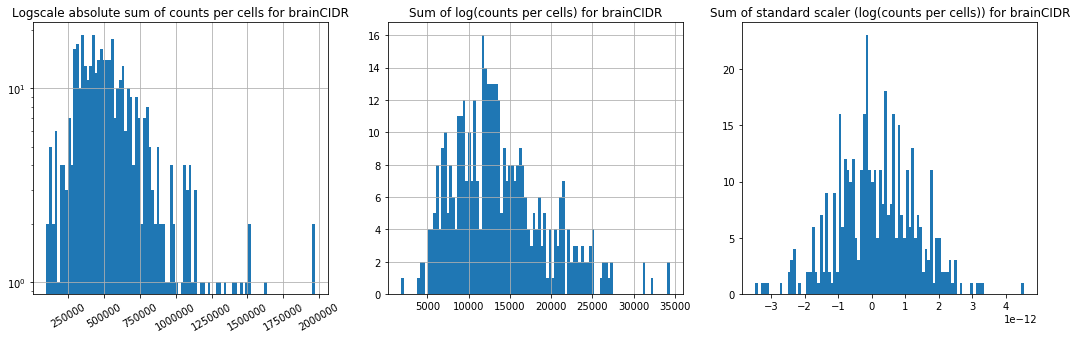

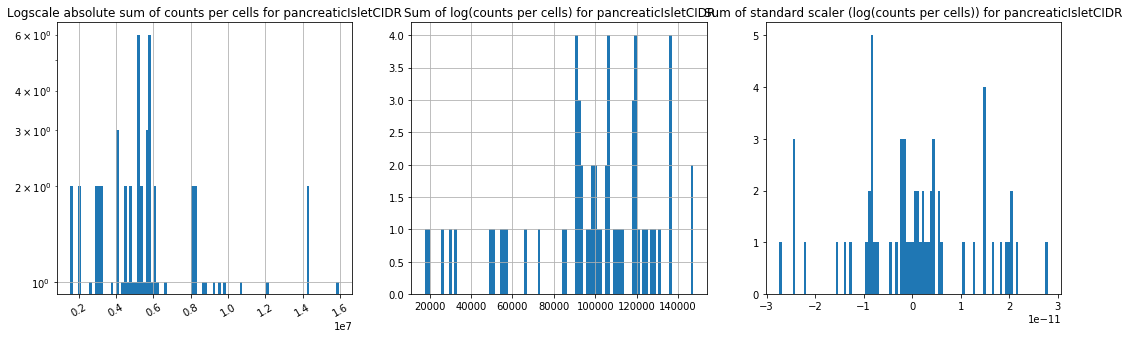

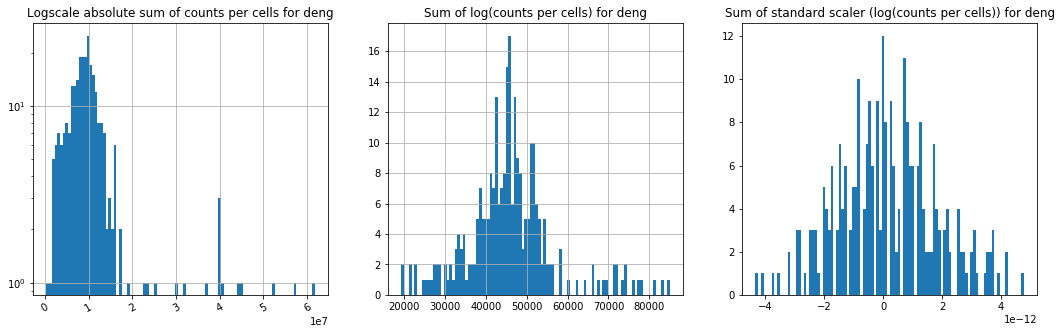

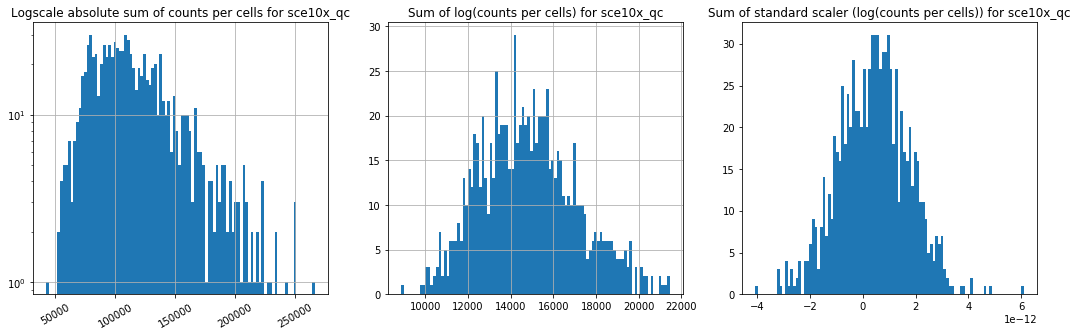

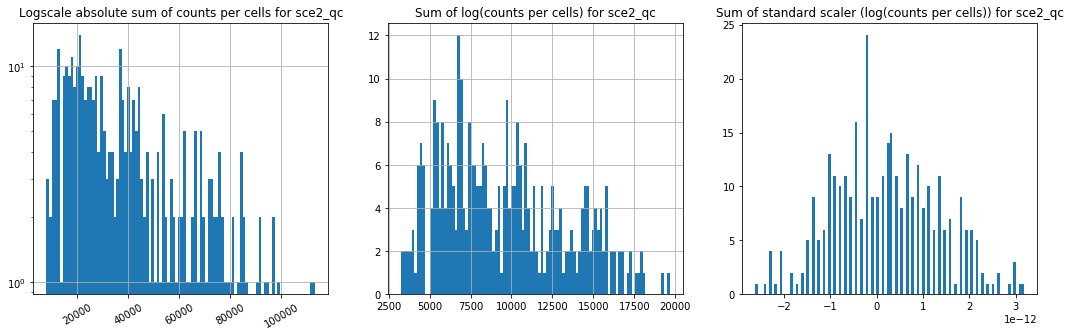

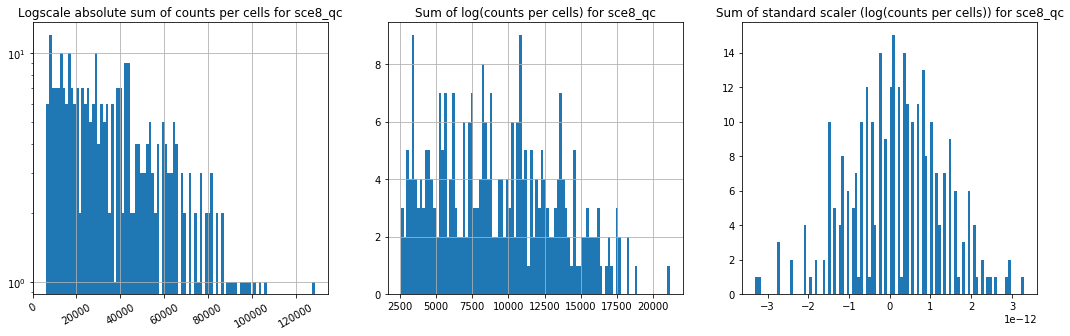

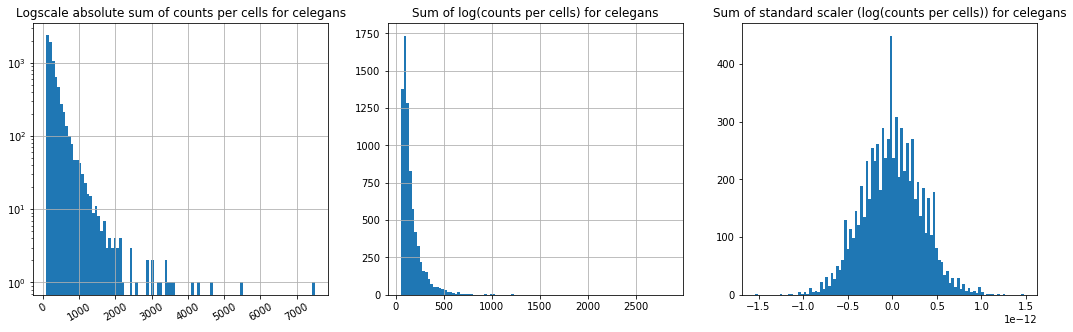

In [60]:
pdf = matplotlib.backends.backend_pdf.PdfPages("datasets.pdf")
for dataset in datasets:
    df, truth = utils.loadData(dataset)
    ## Generate plots
    plt.figure(figsize=(18,5))
    plt.subplot(131)
    plt.title(f'Logscale absolute sum of counts per cells for {dataset}')
    df.sum(axis=1).hist(bins = 100, log = True)
    plt.xticks(rotation = 30)

    plt.subplot(132)
    df = np.log1p(df)
    plt.title(f'Sum of log(counts per cells) for {dataset}')
    df.sum(axis=1).hist(bins = 100)
    
    plt.subplot(133)
    scaledDf = StandardScaler().fit_transform(df.T).T
    plt.title(f'Sum of standard scaler (log(counts per cells)) for {dataset}')
    plt.hist(scaledDf.sum(axis=1), bins = 100)
    pdf.savefig()

    
pdf.close()

In [27]:
r.set_index('name', inplace=True, drop = True)
r = r.T
r = r.applymap("{:,.0f}".format)

In [28]:
r

name,brainCIDR,pancreaticIsletCIDR,deng,sce10x_qc,sce2_qc,sce8_qc,celegans
Total number of cells,420,60,268,902,340,296,"7,603"
Total number of genes,"22,085","180,253","22,431","16,468","14,804","15,571","12,355"
Max dataset value,"58,272","1,429,282","693,974","8,556","2,946","2,495",219
Percentage of 0 values,81,78,60,45,52,56,99
Number of clusters,8,6,10,3,8,8,nan
Expected cluster size base on expected #clusters,52,10,26,300,42,37,nan
Average number of genes per cell,"4,107","39,970","8,907","9,054","7,095","6,775",175
Percentual average number of genes per cell,19,22,40,55,48,44,1
Std number of genes per cell,"1,686","12,621","1,725",773,"1,854","2,143",121
Kurtosis number of genes per cell,5,0,2,-0,-1,-1,30


In [30]:

r[['celegans']].dropna()

name,celegans
Total number of cells,"7,603"
Total number of genes,"12,355"
Max dataset value,219
Percentage of 0 values,99
Number of clusters,nan
Expected cluster size base on expected #clusters,nan
Average number of genes per cell,175
Percentual average number of genes per cell,1
Std number of genes per cell,121
Kurtosis number of genes per cell,30
